In [2]:
import numpy as np 
import pandas as pd 
import time
pd.set_option('display.max_columns', None) 


# PREPROCESAMIENTO
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score


# PIPELINES
from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import set_config
# configuración para mostrar los pipelines de modo grafico
set_config(display=None)


# MODELOS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


# VISUALIACIÓN
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Accedemos a los datos crudos

In [ ]:
#Establezco la dirección del archivo
file_location="twic_master.csv"

#Leo el data set usando la librería pandas y se almacena en el objeto Dataframe llamado datos_crudos  
datos_crudos=pd.read_csv(file_location)

In [ ]:
print("El tamaño del dataset original es de:")
datos_crudos.shape

In [ ]:
#Listamos todas las columnas del dataset
datos_crudos.columns

## Definimos el preprocesamiento para el pipeline con una función:

In [ ]:
#Funcion para crear la columna cantidad de movimientos
def cant_mov(x):
    if type(x) is str:
        return len(x.replace(" ", "").split('.'))
    else:
        return np.NaN

#Definimos una función que se aplicará sobre cada registro para limpiar resultados
def limpiar_resultado(x):
    if x=='1-0':
        return 0
    elif x=='0-1':
        return 1
    elif x=='1/2-1/2':
        return 2
    else: 
        return np.NaN


#Funcion pre-pipeline (con control="blitz","rapid" de tiempo para elegir)

def pre_pipeline(X, control):
        #Filtro juegos de 960
        X = X[ (datos_crudos.Variant.isna()) & (datos_crudos.FEN.isna()) & (datos_crudos.SetUp.isna()) ]
        # Despues tiro estas columnas que ya no me dicen nada
        #X = X.drop(["Variant", "FEN", "SetUp"], axis=1)

        #Ponemos columnas en minuscula
        cols = ['Event', 'Opening', 'Variation', 'EventType']
        for feature in cols:
                X[feature] = X[feature].str.lower().str.strip()

        #Filtro control de tiempo
        
        X=X[(X.Event.str.contains(control)) | (X.EventType.str.contains(control))]
        # Quitamos las columnas event y eventype
        #X=X.drop(columns=['Event', 'EventType'])

        #Pasamos la columna a Date
        X["Date"] = pd.to_datetime(X["Date"])
        #Filtramos aquellos años que esten dos desvíos standar por debajo de la media
        X=X.loc[X['Date'].dt.year>X['Date'].dt.year.mean()-3*X['Date'].dt.year.std()] 
        
        #FILTRO RESULTADOS MAL CARGADOS
        X = X[(X.Result=="1-0") | (X.Result=="0-1") | (X.Result=="1/2-1/2")]
    
        #Limpiamos Resultado
        X['Result'] = X['Result'].apply(limpiar_resultado)  

        #PISO "mainline_moves" con el nro de movidas
        X['mainline_moves'] = X['mainline_moves'].apply(cant_mov) 
        
        #ELIMINO registros con nans en Elo ó ID
        X=X.dropna(subset=["WhiteElo","BlackElo","WhiteFideId","BlackFideId"])
        
        return X


In [ ]:
df_bz=pre_pipeline(datos_crudos, "blitz")
df_rd=pre_pipeline(datos_crudos, "rapid")

In [ ]:
display(df_bz.shape, df_rd.shape)

# DATASETS LIMPIOS Y SEPARADOS POR CONTROL DE TIEMPO

## Los datos crudos pasan por la función de facu y salen los dos dataframes de blitz y rapid con 29 columnas cada uno.

(ES IMPORTANTE QUE ENTRE CON LAS 29 COLUMNAS!)

Las dos celdas que siguen generan cada uno de los dataframes:

In [ ]:
#url_bz = 'https://raw.githubusercontent.com/Facundo-Peloso/DH-TP-1---Grupo-10/main/TP%20FINAL/Chess/blitz_pipe_29.csv'
#df_bz = pd.read_csv(url_bz)

In [90]:
#url_rd = 'https://raw.githubusercontent.com/Facundo-Peloso/DH-TP-1---Grupo-10/main/TP%20FINAL/Chess/rapid_pipe_29.csv'
#df_rd = pd.read_csv(url_rd)

## Hagamos una funcion que reciba el df y separe en features  "X" y target "y", realizando también el train_test_split y devolviendo todo listo para meter en el pipeline:

In [158]:
def tts(dfr):
  # Separemos features y target
  y = dfr.Result
  X = dfr.drop(["Result"],axis=1)

  # Hagamos un split en blitz:
  return train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
  # a la funcion la llamamos igual que a un tr_ts_split, pero con el dfr con features y target de argumento

In [167]:
X_train_bz, X_test_bz, y_train_bz, y_test_bz = tts(df_bz)
X_train_rd, X_test_rd, y_train_rd, y_test_rd = tts(df_rd)

## Definamos los transformers y usémolos para armar un pipeline:

Todo en una única celda

In [171]:
T1 = ColumnTransformer([('drop', "drop", ['twic_number', 'White', 'Black', 'Date', 'EventDate', 'Event',
                                          'Site', 'Online', 'Round', 'ECO', 'Variation','WhiteTitle',
                                          'BlackTitle', 'WhiteTeam', 'BlackTeam', 'EventType','FEN',
                                          'SetUp', 'Variant', 'Board', 'PlyCount', 'EventCategory'])], remainder = "passthrough")

T2 = ColumnTransformer(
[('imputa_movidas', SimpleImputer(strategy='mean'), [0]),
('imputa_apertura', SimpleImputer(strategy='most_frequent'), [1])],
remainder='passthrough')

T3 = ColumnTransformer(
[('ohe_ids', OneHotEncoder(min_frequency=200, handle_unknown='infrequent_if_exist', sparse_output=False), [2,3]),
('ohe_apertura', OneHotEncoder(min_frequency=2000, handle_unknown='infrequent_if_exist', sparse_output=False), [1])],
remainder = 'passthrough')

T4 = ColumnTransformer([('escaleo', MinMaxScaler(), [-1, -2, -3])], remainder = "passthrough")

arbol = DecisionTreeClassifier(max_depth=7)

pasitos = [('T1', T1), ('T2', T2), ('T3', T3), ('T4', T4), ('clf', arbol)]
pipe = Pipeline(pasitos)

## Veamos como anda el pipe con su arbolito default:

In [172]:
pipe.fit(X_train_bz, y_train_bz)

Pipeline(steps=[('T1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['twic_number', 'White',
                                                   'Black', 'Date', 'EventDate',
                                                   'Event', 'Site', 'Online',
                                                   'Round', 'ECO', 'Variation',
                                                   'WhiteTitle', 'BlackTitle',
                                                   'WhiteTeam', 'BlackTeam',
                                                   'EventType', 'FEN', 'SetUp',
                                                   'Variant', 'Board',
                                                   'PlyCount',
                                                   'EventCategory'])])),
                ('T2',
                 ColumnTransformer(remaind...
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=200,
                                                                sparse_output=False),
                                                  [2, 3]),
                                                 ('ohe_apertura',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=2000,
                                                                sparse_output=False),
                                                  [1])])),
                ('T4',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('escaleo', MinMaxScaler(),
                                                  [-1, -2, -3])])),
                ('clf', DecisionTreeClassifier(max_depth=7))])

In [173]:
y_pred_bz = pipe.predict(X_test_bz)

In [174]:
accuracy_score(y_test_bz, y_pred_bz)

0.5857408623331145

In [137]:
pipe.get_params()

{'memory': None, 'steps': [('T1', ColumnTransformer(remainder='passthrough',
                     transformers=[('drop', 'drop',
                                    ['twic_number', 'White', 'Black', 'Date',
                                     'EventDate', 'Event', 'Site', 'Online',
                                     'Round', 'ECO', 'Variation', 'WhiteTitle',
                                     'BlackTitle', 'WhiteTeam', 'BlackTeam',
                                     'EventType', 'FEN', 'SetUp', 'Variant',
                                     'Board', 'PlyCount', 'EventCategory'])])),
  ('T2', ColumnTransformer(remainder='passthrough',
                     transformers=[('imputa_movidas', SimpleImputer(), [0]),
                                   ('imputa_apertura',
                                    SimpleImputer(strategy='most_frequent'),
                                    [1])])),
  ('T3', ColumnTransformer(remainder='passthrough',
                     transformers=[('ohe_ids

## Hagamos un gridsearch para ver cómo performan los distintos clasificadores:

In [139]:
# Y SI QUIERO COMPARAR CLASIFICADORES Y AL MISMO TIEMPO TUNEARLOS:

log_reg = LogisticRegression()
nb = BernoulliNB()
knn = KNeighborsClassifier()
svm = SVC()
mlp = MLPClassifier(max_iter=500)
dt = DecisionTreeClassifier()
et = ExtraTreesClassifier()
rf = RandomForestClassifier()
xgb = XGBClassifier()


# con el nombre "M" llamo a los distintos modelos
# con el doble guion bajo "__" accedo a los hiperparámetros
# el grid entra como una lista de diccionarios

parametros = [
    {'clf': [log_reg], 'clf__C': [0.01, 0.1, 1,2, 5, 10]},
    {'clf': [rf], 'clf__n_estimators': [50, 100, 200]},
    {'clf': [dt], 'clf__max_depth': [6, 7, 8, 9, 10]},
    {'clf': [nb]},
    {'clf': [mlp]},
    {'clf': [knn], 'clf__n_neighbors': [70, 100, 130, 160]},
    {'clf': [xgb], 'clf__colsample_bytree': [0.2, 0.4], 'clf__max_depth': [2, 3, 4, 5]}]


folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search = GridSearchCV(pipe, parametros, cv=folds, scoring="f1_micro", n_jobs=-1)

In [140]:
ini = time.time()
search.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")

2.312974214553833 minutos de optimización


In [141]:
search.best_params_

{'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.4, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, ...),
 'clf__colsample_bytree': 0.4,
 'clf__max_depth': 3}

## Veamos el score de todos los modelos:

In [142]:
res = pd.DataFrame(search.cv_results_).sort_values(by = "rank_test_score").set_index("rank_test_score").loc[:,["params","mean_test_score"]]
res

,params,mean_test_score
rank_test_score,,
1,"{'clf': XGBClassifier(base_score=None, booster...",0.593426
2,"{'clf': XGBClassifier(base_score=None, booster...",0.592413
3,"{'clf': XGBClassifier(base_score=None, booster...",0.592359
4,"{'clf': XGBClassifier(base_score=None, booster...",0.591100
5,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.590566
6,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.590402
7,{'clf': MLPClassifier(max_iter=500)},0.590389
8,"{'clf': KNeighborsClassifier(), 'clf__n_neighb...",0.590088
9,"{'clf': XGBClassifier(base_score=None, booster...",0.588939


## Testeamos el mejor modelo:

In [145]:
y_pred_search_bz = search.predict(X_test_bz)

accuracy_score(y_test_bz, y_pred_search_bz)

0.5989275552637339

## Visualicemos la performance del mejor modelo del gridsearch:



In [144]:
# Esta funcion toma los sets (X_test, y_test) y la predicción y_pred de un modelo
# Para entregar gráficas y métricas de score

def GRAFICAS(X_test, y_test, y_pred):
    
    y_test = pd.Series(y_test)
    y_pred = pd.Series(y_pred, index=y_test.index)
    
    c = confusion_matrix(y_test, y_pred) # mostramos la matriz de confusion
    plt.figure(figsize=(4  ,4))
    ax= plt.subplot()
    sns.heatmap(c, cmap="coolwarm", annot=True, fmt="d")
    ax.set_xlabel('Resultados predecidos')
    ax.set_ylabel('Resultados del test')
    ax.xaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.yaxis.set_ticklabels(['B(0)', 'N(1)', "T(2)"])
    ax.set_title('Matriz de Confusión')
    plt.show()
    

    print(f"El accuracy global del modelo es {accuracy_score(y_test, y_pred)}.")

    # Me armo un df de scores para cada resultado
    scores = pd.DataFrame({"Resultado":range(3),
                         "sensibilidad":pd.Series(recall_score(y_test, y_pred, average=None)),
                         "precisión":pd.Series(precision_score(y_test, y_pred, average=None)),
                         "f1":pd.Series(f1_score(y_test, y_pred, average=None))})
    scores.index.name='Resultado'
    print(f"\n\nEstos son los scores para cada resultado")

    display(scores.loc[:,"sensibilidad":].transpose().round(3))


    
    
    # hacemos un melt sobre Resultados para graficar
    df = scores.melt("Resultado", var_name='scores', value_name='Scores')
    # graficamos los scores para cada resultado
    sns.catplot(x="Resultado", y="Scores", hue='scores', data=df, kind='point')
    #plt.savefig(f"tp3_{type(modelo)}.png")
    plt.show()

    
    
    # Mostremos los errores cometidos

    err = y_test != y_pred # Hacemos una mascara de errores

    print(f"\n\nEstos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):") 

    err1 = pd.DataFrame({"Mal sensado":y_test[err].value_counts(), "Mal predecido":y_pred[err].value_counts()})
    tot1 = err1["Mal sensado"].sum()
    tot2 = err1["Mal predecido"].sum()
    err1.loc["Total"] = [tot1,tot2]
    err1.index.name='Resultado'
    display(err1.transpose())

    # Un dataframe de errores:
    errores = pd.DataFrame({"y_test":y_test[err], "y_pred":y_pred[err]})
    errores["frecuencia"] = errores.apply(lambda x: c[x.y_test,x.y_pred] ,axis=1)
    errores = errores.sort_values(by=["frecuencia",'y_test', 'y_pred'],ascending=[False,False,False])

    print(f"\n\nAquí se muestra la frecuencia de cada uno de los {errores.shape[0]} errores cometidos:")
    display (errores.drop_duplicates().set_index('frecuencia').transpose())

    
    
    # Y para finalizar graficamos los errores de predicción,
    # con la perspectiva puesta en Los Elos, que son nuestros
    # mejores predictores
    X_test["Errores de Sensibilidad"] = y_test
        
    X_test["Errores de Precisión"] = y_pred
    
    
    print("\n\nEstos son los errores de recall (etiquetas del test mal predecidas):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Sensibilidad", plot_kws={"s": 1}, palette="Dark2")
    plt.show()

    # Acá se va a ver cómo los modelos predicen empates sólo para los jugadores de mayor Elo.
    print("\n\nEstos son los errores de precisión (predicciones erróneas del modelo):")
    sns.pairplot(X_test[err], vars=['WhiteElo', 'BlackElo'], hue = "Errores de Precisión", plot_kws={"s": 1}, palette="Dark2")
    plt.show()
    print("Los errores de precisión a su vez revelan las fronteras de decisión del modelo")
    
    
    # Y un poco mas en detalle el tipo de error:
    X_err = X_test.loc[err]
    X_err["(Test, Pred)"] = X_err.apply(lambda x: (x["Errores de Sensibilidad"], x["Errores de Precisión"]), axis=1)
    
    print("\n\nAquí se grafican los seis tipos de errores posibles:")
    sns.pairplot(X_err, vars=['WhiteElo', 'BlackElo'], hue = "(Test, Pred)", plot_kws={"s": 1}, palette="Paired")
    plt.show()

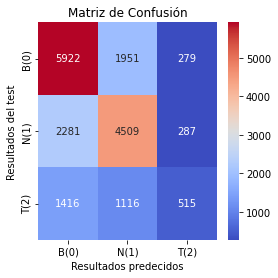

El accuracy global del modelo es 0.5989275552637339.


Estos son los scores para cada resultado


Resultado,0,1,2
sensibilidad,0.726,0.637,0.169
precisión,0.616,0.595,0.476
f1,0.666,0.615,0.250


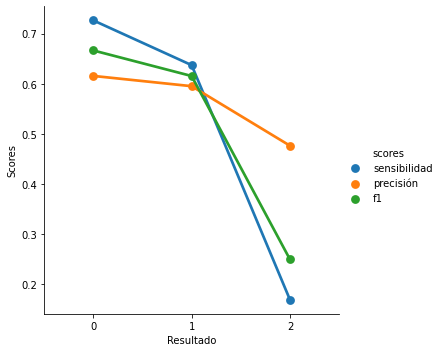



Estos son los errores de sensado (resultado mal identificado) y los errores de presición (resultado mal asignado):


Resultado,0,1,2,Total
Mal sensado,2230,2568,2532,7330
Mal predecido,3697,3067,566,7330




Aquí se muestra la frecuencia de cada uno de los 7330 errores cometidos:


frecuencia,2281,1951,1416,1116,287,279
y_test,1,0,2,2,1,0
y_pred,0,1,0,1,2,2




Estos son los errores de recall (etiquetas del test mal predecidas):


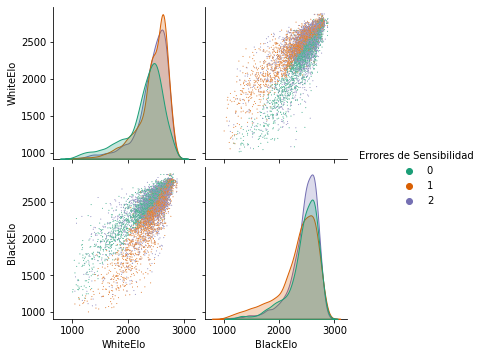



Estos son los errores de precisión (predicciones erróneas del modelo):


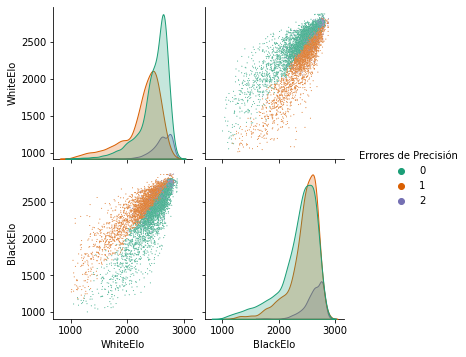

Los errores de precisión a su vez revelan las fronteras de decisión del modelo


Aquí se grafican los seis tipos de errores posibles:


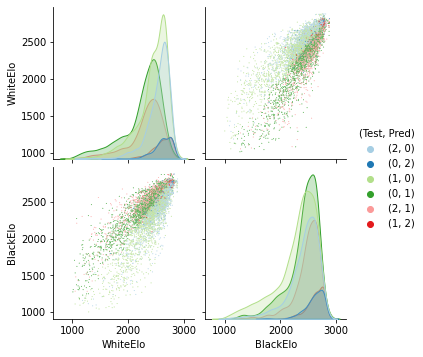

In [146]:
GRAFICAS(X_test_bz, y_test_bz, y_pred_search_bz)

## Para afinar con xgb, podemos armar un pipeline cambiando el ultimo paso y metiendo el booster como clasificador:

In [150]:
# afinemos con xgb:
display(pasitos[4])
#pongamos al xgb como ultimo paso:
pasitos[4] = ("clf", xgb)
pipe = Pipeline(pasitos)
display(pipe)

('clf', DecisionTreeClassifier(max_depth=7))

Pipeline(steps=[('T1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['twic_number', 'White',
                                                   'Black', 'Date', 'EventDate',
                                                   'Event', 'Site', 'Online',
                                                   'Round', 'ECO', 'Variation',
                                                   'WhiteTitle', 'BlackTitle',
                                                   'WhiteTeam', 'BlackTeam',
                                                   'EventType', 'FEN', 'SetUp',
                                                   'Variant', 'Board',
                                                   'PlyCount',
                                                   'EventCategory'])])),
                ('T2',
                 ColumnTransformer(remaind...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

## Además quiero cambiar hiperparámetros de los transformers, por ejemplo la cantidad de dummies a generar.

In [154]:
# 

parametros_xgb = [
    {
     'clf': [xgb],
     'clf__colsample_bytree': [0.4, 0.6],
     'clf__max_depth': [3, 4],
     'clf__n_estimators': [400],
     'clf__learning_rate': [0.1, 0.15],
     'T3__ohe_ids__min_frequency': [100,200], # acá me meto en los hiperparámetros del preprocesamiento
     'T3__ohe_apertura__min_frequency': [2000,3000] # va ha probar con dummies para los jugadores que aparece más de 100, 200 ... veces
     # va a probar con dummies para las aperturas que aparecen más de 2000, 3000 ... veces
     
     }]



folds = StratifiedKFold(n_splits=2, random_state=0, shuffle=True)
search_xgb = GridSearchCV(pipe, parametros_xgb, cv=folds, scoring="f1_micro", n_jobs=-1)

También podría probar si es mejor imputar con la media o la mediana para las movidas, tendría que agregar:


```
'T2__imputa_movidas__strategy': ["mean", "median"]
```
al grid de parámetros.


In [ ]:

ini = time.time()
search_xgb.fit(X_train_bz, y_train_bz)
fin = time.time()
print(f"{(fin-ini)/60} minutos de optimización")


In [58]:
pd.DataFrame(search_xgb.cv_results_).sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_clf__colsample_bytree,param_clf__learning_rate,param_clf__max_depth,param_clf__n_estimators,param_tr2__ohe_apertura__min_frequency,param_tr2__ohe_ids__min_frequency,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
47,24.113586,0.334868,1.649319,0.424288,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,3000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
44,24.570733,0.473732,1.198019,0.016313,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,2000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
43,23.872967,0.694758,1.289183,0.134993,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,2000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
46,24.696386,0.021811,1.186350,0.001207,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,4,400,3000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589231,0.593160,0.591196,0.001964,45
22,16.484044,0.101468,0.983597,0.007221,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,3000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
20,16.120664,0.051126,1.107028,0.113360,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,2000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
19,16.064359,0.102789,1.001025,0.004330,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,2000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
23,16.111877,0.038510,0.969518,0.019105,"XGBClassifier(base_score=None, booster=None, c...",0.4,0.15,4,400,3000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.589806,0.592613,0.591209,0.001403,41
41,19.016148,0.193140,0.926443,0.021881,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,3,400,3000,300,"{'clf': XGBClassifier(base_score=None, booster...",0.591885,0.593078,0.592482,0.000596,37
40,19.114181,0.036485,1.751895,0.082704,"XGBClassifier(base_score=None, booster=None, c...",0.6,0.15,3,400,3000,200,"{'clf': XGBClassifier(base_score=None, booster...",0.591885,0.593078,0.592482,0.000596,37


In [60]:
y_search_xgb_bz = search_xgb.predict(X_test_bz)

In [61]:
accuracy_score(y_test_bz, y_search_xgb_bz)

0.6038520463996498